In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score, silhouette_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import preprocessing
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from keras.optimizers import Adam, SGD


from PIL import Image
Image.MAX_IMAGE_PIXELS = None
# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from keras.optimizers import RMSprop
#from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler

import random
import time
import cv2
from tqdm import tqdm

Num GPUs Available:  0


In [2]:
image_folder = "./Flipkart/Images/"
# Load CSV into Pandas DataFrame
text_data_path = r'./Flipkart/flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(text_data_path)
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
270,7ee2e665b7de2e1cc29e3c65bde0c318,2015-12-01 12:40:44 +0000,http://www.flipkart.com/mavi-237mbb-showpiece-...,Mavi 237MBB Showpiece - 15 cm,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIE7QCY6ZQSUF6E,3280.0,1290.0,7ee2e665b7de2e1cc29e3c65bde0c318.jpg,False,Buy Mavi 237MBB Showpiece - 15 cm for Rs.129...,No rating available,No rating available,Mavi,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
658,5ae4626271e8eefe5eb2aaf42c00724f,2015-12-31 09:19:31 +0000,http://www.flipkart.com/creative-width-decor-m...,Creative Width Decor Medium Vinyl Sticker Sticker,"[""Home Decor & Festive Needs >> Wall Decor & C...",STIE6JA4BCHZFQ89,999.0,499.0,5ae4626271e8eefe5eb2aaf42c00724f.jpg,False,Buy Creative Width Decor Medium Vinyl Sticker ...,No rating available,No rating available,Creative Width Decor,"{""product_specification""=>[{""key""=>""Number of ..."
900,d3f4a4336324a3d180de23df1e75b9b7,2016-05-22 10:35:27 +0000,http://www.flipkart.com/loreal-diarichesse-no-...,Loreal Diarichesse No- 5 Light Brown ( Pack of...,"[""Beauty and Personal Care >> Hair Care >> Hai...",HRCEGVR9HBWKYFPD,4295.0,3295.0,d3f4a4336324a3d180de23df1e75b9b7.jpg,False,Key Features of Loreal Diarichesse No- 5 Light...,No rating available,No rating available,Loreal,"{""product_specification""=>[{""key""=>""Ammonia Fr..."
124,640fd08bb3ba538d67a5c0c2c61a5c4c,2016-06-24 16:03:26 +0000,http://www.flipkart.com/sos-computrised-lcd-in...,SOS COMPUTRISED LCD INTRFERENTIAL UNIT-125PROG...,"[""Beauty and Personal Care >> Health Care >> H...",ELTEJXM48D3HAUFB,19500.0,17550.0,640fd08bb3ba538d67a5c0c2c61a5c4c.jpg,False,Specifications of SOS COMPUTRISED LCD INTRFERE...,No rating available,No rating available,SOS,"{""product_specification""=>[{""key""=>""Treatment ..."
736,e33795f66b2a42ac56095ae704ab25b6,2016-04-13 02:13:26 +0000,http://www.flipkart.com/antiqueshop-abkl-pl-pn...,AntiqueShop ABKL_PL_PNK_PNK,"[""Beauty and Personal Care >> Bath and Spa >> ...",LFHEGUEKPTJY6HBW,599.0,349.0,e33795f66b2a42ac56095ae704ab25b6.jpg,False,Key Features of AntiqueShop ABKL_PL_PNK_PNK So...,No rating available,No rating available,AntiqueShop,"{""product_specification""=>[{""value""=>""3 Back L..."


In [3]:
# Split the product_category_tree column into subcategory columns and keep only the 2 first catagory levels
category_lables = df['product_category_tree'].str.split(' >> ', expand=True).iloc[:, :2][0]

# Remove square brackets and double quotes from all strings in the DataFrame
df['category'] = category_lables.apply(lambda x: str(x).replace('[', '').replace('"', '').replace(']', ''))
list_categories = df['category'].unique().tolist()
df['category']

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category, Length: 1050, dtype: object

In [4]:
le = preprocessing.LabelEncoder()
le.fit(df["category"])
df['category_encoded'] = le.transform(df["category"])
category_dict = dict(zip(df['category'], df['category_encoded']))
category_dict

{'Home Furnishing': 4,
 'Baby Care': 0,
 'Watches': 6,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 5,
 'Beauty and Personal Care': 1,
 'Computers': 2}

# Utility functions

* Metrics

In [5]:
def calculate_ari(labels_true, labels_pred):
    ari = np.round(adjusted_rand_score(labels_true, labels_pred), 2)
    return ari

def calculate_silhouette_score(data, labels):
    silhouette = np.round(silhouette_score(data, labels), 2)
    return silhouette

In [6]:
def conf_mat_transform2(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print(type(corresp))
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    if not np.array_equal(corresp, np.array([0, 1, 2, 3, 4, 5, 6])):
        labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
        return labels['y_pred_transform'], corresp
    else:
        return labels['y_pred'], corresp

In [7]:
def create_model_fct(model, n_class, dropout_rate, optimization='rmsprop'):

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(n_class, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimization, metrics=["accuracy"])

    print(model.summary())
    
    return model

In [8]:
batch_size = 64

In [9]:
def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='category',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

* Create classification model

In [10]:
def create_model_fct(model, n_class, dropout_rate, optimization='rmsprop'):

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(n_class, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimization, metrics=["accuracy"])

    print(model.summary())
    
    return model

* Initial image set up

In [11]:
def image_prep_fct(data):
    prepared_images = []  # List to store prepared images
    for image_num in range(data.shape[0]):
        # Load image, resize to (224, 224), and convert to NumPy array
        img = load_img(glob(os.path.join(image_folder, data['image'].tolist()[image_num]))[0],
                       target_size=(224, 224))
        img = img_to_array(img)

        # Reshape the array to match the expected input shape
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))

        # Preprocess the image according to the requirements of the VGG16 model
        img = preprocess_input(img)

        # Append the prepared image to the list
        prepared_images.append(img)

    # Convert the list of prepared images to a NumPy array
    prepared_images_np = np.array(prepared_images)
    
    return prepared_images_np

# Data augmentation with ImageDataGenerator

In [12]:
batch_size = 64

In [13]:
# n order to shuffle the images, initially sorted by class.
df_data_aug = df.copy()
df_data_aug['image_path'] = df_data_aug['image'].apply(lambda x: glob(os.path.join(image_folder, x))[0])
df_data_aug.image_path

df_aug_dev, df_aug_test = train_test_split(df_data_aug, test_size=0.15)

df_aug_dev.shape, df_aug_test.shape

((892, 18), (158, 18))

In [14]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    #rescale=1. / 255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.95,1.05],
    zoom_range=[0.9,1.1],
    validation_split=0.177,
    preprocessing_function=preprocess_input
    )

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input
    )

print('training')
df_aug_dev_train_flow = data_flow_fct(df_aug_dev, datagen_train, data_type='training')
print('validation')
df_aug_dev_val_flow = data_flow_fct(df_aug_dev, datagen_train, data_type='validation')
print('test')
df_aug_dev_test_flow = data_flow_fct(df_aug_test, datagen_test, data_type=None)


training
Found 735 validated image filenames belonging to 7 classes.
validation
Found 157 validated image filenames belonging to 7 classes.
test
Found 158 validated image filenames belonging to 7 classes.


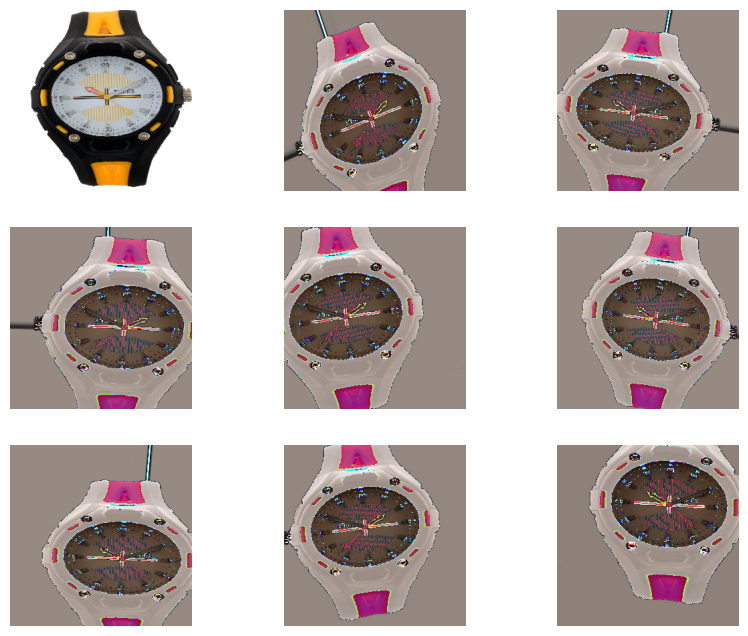

In [15]:
#image_orig = Image.open(df_aug_dev.image_path[404])
#image_path = glob(os.path.join(image_folder, filename))[0]
example_image_path = glob(os.path.join(image_folder, os.listdir(image_folder)[100]))[0]
image_orig = load_img(example_image_path, target_size=(272, 272))

#image_orig_array = img_to_array(image_orig)
image_orig_array = np.asarray(image_orig)

image_orig_array = np.expand_dims(image_orig_array, axis=0)

#image_orig_array = preprocess_input(image_orig_array)

# Reshape the input image for the generator
#image_to_gen = image_orig_array.reshape((1,) + image_orig_array.shape)
image_to_gen = image_orig_array

# iterator
aug_iter = datagen_train.flow(image_to_gen, batch_size=1)

# Generate samples and plot
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
axs = ax.reshape(1, -1)[0]
axs[0].imshow(image_orig)
axs[0].axis('off')
# Generate batch of images
for i in range(8):
    # Convert to unsigned integers
    image= next(aug_iter)[0].astype('uint8')

    # Plot image
    axs[i+1].imshow(image)
    axs[i+1].axis('off')

# Show the plots
plt.axis('off')
plt.show()


#### 3-1 VGG16 Data Augmentation

In [16]:
model_vgg_aug = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_vgg_aug = create_model_fct(model_vgg_aug, 7, 0.5)

# Define the path to save best weights
model_vgg_aug_save_path = "./model_vgg_aug_best_weights.h5"

# Create callbacks including the custom history saver
checkpoint_vgg_aug = ModelCheckpoint(model_vgg_aug_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks_list_vgg_aug = [checkpoint_vgg_aug, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
history_vgg_aug = model_vgg_aug.fit(df_aug_dev_train_flow, validation_data=df_aug_dev_val_flow, epochs=50, batch_size=batch_size, 
                          callbacks=callbacks_list_vgg_aug, verbose=1)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 4.4092 - accuracy: 0.4095 
Epoch 1: val_loss improved from inf to 1.28510, saving model to .\model_vgg_aug_best_weights.h5
12/12 [==============================] - 183s 15s/step - loss: 4.4092 - accuracy: 0.4095 - val_loss: 1.2851 - val_accuracy: 0.7197
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.8754 - accuracy: 0.5973 
Epoch 2: val_loss improved from 1.28510 to 0.98412, saving model to .\model_vgg_aug_best_weights.h5
12/12 [==============================] - 174s 15s/step - loss: 1.8754 - accuracy: 0.5973 - val_loss: 0.9841 - val_accuracy: 0.7643
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.2489 - accuracy: 0.7088 
Epoch 3: val_loss did not improve from 0.98412
12/12 [==============================] - 181s 15s/step - loss: 1.2489 - accuracy: 0.7088 - val_loss: 0.9988 - val_accuracy: 0.7834
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.9786 - ac

In [18]:
# Score de l'epoch optimal
model_vgg_aug.load_weights(model_vgg_aug_save_path)

loss_aug_dev_val, accuracy_aug_dev_val, = model_vgg_aug.evaluate(df_aug_dev_val_flow, verbose=False)
print("Validation Accuracy for VGG16 Model data augmentation approach:  {:.4f}".format(accuracy_aug_dev_val,))

loss_aug_test, accuracy_aug_test = model_vgg_aug.evaluate(df_aug_dev_test_flow, verbose=False)
print("Test Accuracy for VGG16 Model data augmentation approach:  {:.4f}".format(accuracy_aug_test))


Validation Accuracy for VGG16 Model data augmentation approach:  0.8471
Test Accuracy for VGG16 Model data augmentation approach:  0.8101


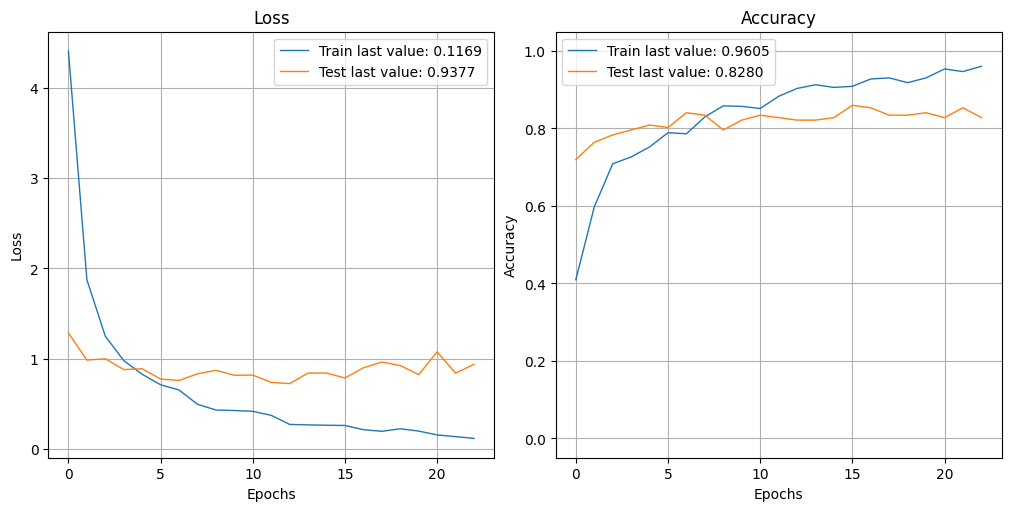

In [19]:
from plot_keras_history import show_history, plot_history

show_history(history_vgg_aug)
plot_history(history_vgg_aug, path="PLOT_VGG_AUG6.png")
plt.close()

#### 3-2 RESNET50 Data Augmentation

In [20]:
model_resnet_aug = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_resnet_aug = create_model_fct(model_resnet_aug, 7, 0.5)

# Define the path to save best weights
model_resnet_aug_save_path = "./model_resnet_aug_best_weights.h5"
# Create callbacks including the custom history saver
checkpoint_resnet_aug = ModelCheckpoint(model_resnet_aug_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks_list_resnet_aug = [checkpoint_resnet_aug, es]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [21]:
history_restnet_aug = model_resnet_aug.fit(df_aug_dev_train_flow, validation_data=df_aug_dev_val_flow, epochs=50, batch_size=batch_size, 
                          callbacks=callbacks_list_resnet_aug, verbose=1)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 2.0526 - accuracy: 0.4735
Epoch 1: val_loss improved from inf to 0.63300, saving model to .\model_resnet_aug_best_weights.h5
12/12 [==============================] - 92s 7s/step - loss: 2.0526 - accuracy: 0.4735 - val_loss: 0.6330 - val_accuracy: 0.7962
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.7763 - accuracy: 0.7578
Epoch 2: val_loss improved from 0.63300 to 0.53934, saving model to .\model_resnet_aug_best_weights.h5
12/12 [==============================] - 87s 7s/step - loss: 0.7763 - accuracy: 0.7578 - val_loss: 0.5393 - val_accuracy: 0.8344
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.8000
Epoch 3: val_loss did not improve from 0.53934
12/12 [==============================] - 91s 8s/step - loss: 0.5864 - accuracy: 0.8000 - val_loss: 0.6164 - val_accuracy: 0.8089
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.5461 - accur

In [22]:
# Score de l'epoch optimal
model_resnet_aug.load_weights(model_resnet_aug_save_path)

loss_resnet_aug_dev_val, accuracy_resnet_aug_dev_val, = model_resnet_aug.evaluate(df_aug_dev_val_flow, verbose=False)
print("Validation Accuracy for RESNET50 Model data augmentation approach:  {:.4f}".format(accuracy_resnet_aug_dev_val,))

loss_resnet_aug_test, accuracy_resnet_aug_test = model_resnet_aug.evaluate(df_aug_dev_test_flow, verbose=False)
print("Test Accuracy for RESNET50 Model data augmentation approach:  {:.4f}".format(accuracy_resnet_aug_test))


Validation Accuracy for RESNET50 Model data augmentation approach:  0.8280
Test Accuracy for RESNET50 Model data augmentation approach:  0.8544


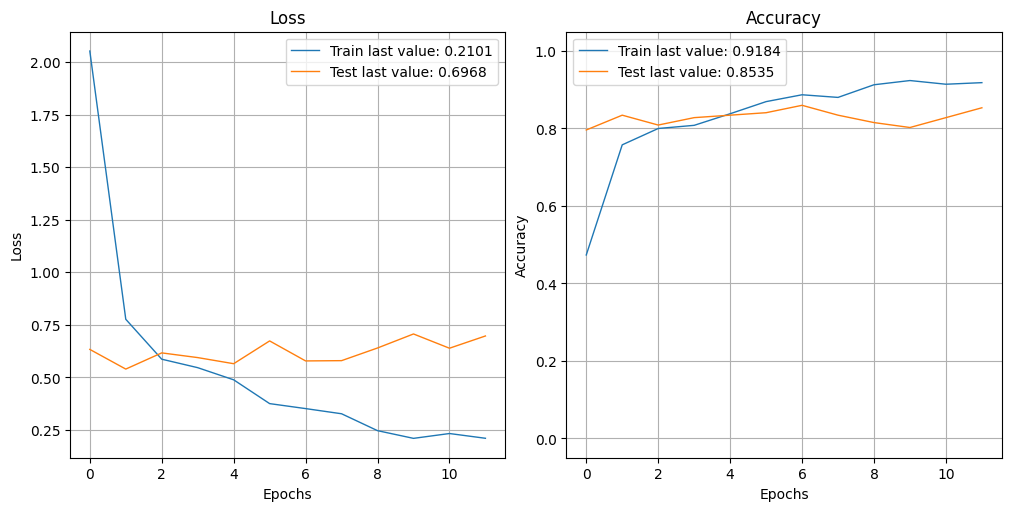

In [23]:
show_history(history_restnet_aug)
plot_history(history_restnet_aug, path="PLOT_RESNET_AUG5.png")
plt.close()

In [24]:
df_aug_dev_val_flow.class_indices

{'Baby Care': 0,
 'Beauty and Personal Care': 1,
 'Computers': 2,
 'Home Decor & Festive Needs': 3,
 'Home Furnishing': 4,
 'Kitchen & Dining': 5,
 'Watches': 6}

#### 3-3 Optimisation des modèles avec Data Augmentation

Training with hyperparameters: ResNet50_adam_0.5
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                           

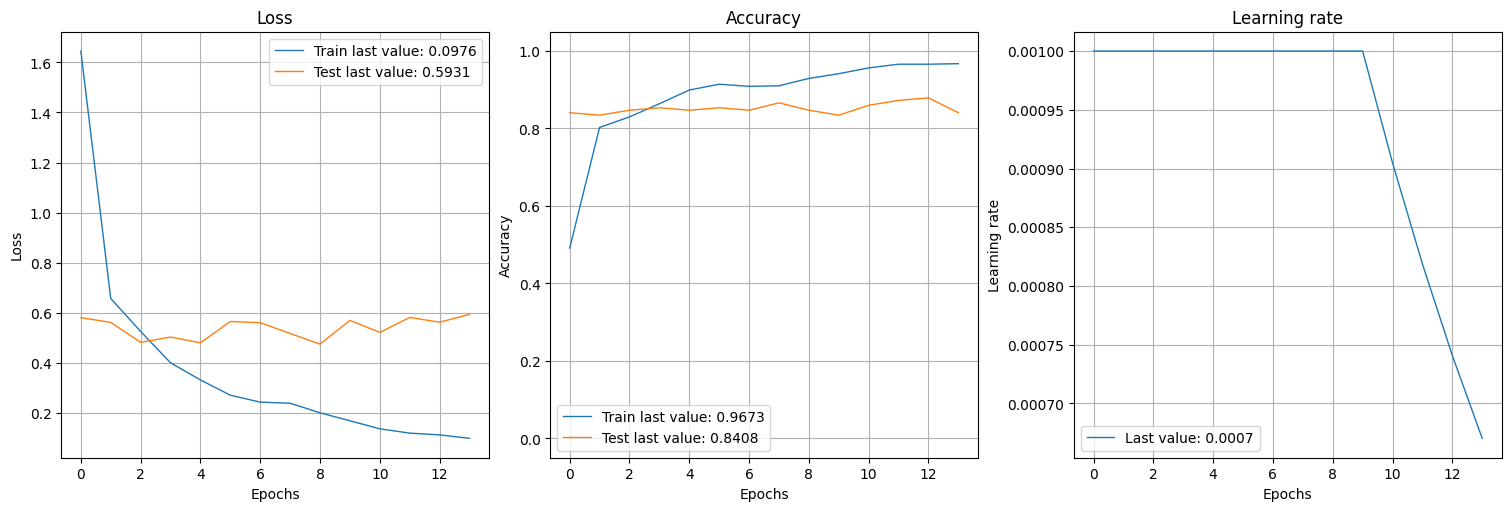

C:\Users\Imtech\AppData\Local\Temp\ipykernel_2720\1957530627.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


      Model epochs  dropout_rate optimization  accuracy validation  \
0  ResNet50     14           0.5         adam             0.872611   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.835443          0.54772   0.652251        2317.683192  
Training with hyperparameters: ResNet50_sgd_0.5
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                    

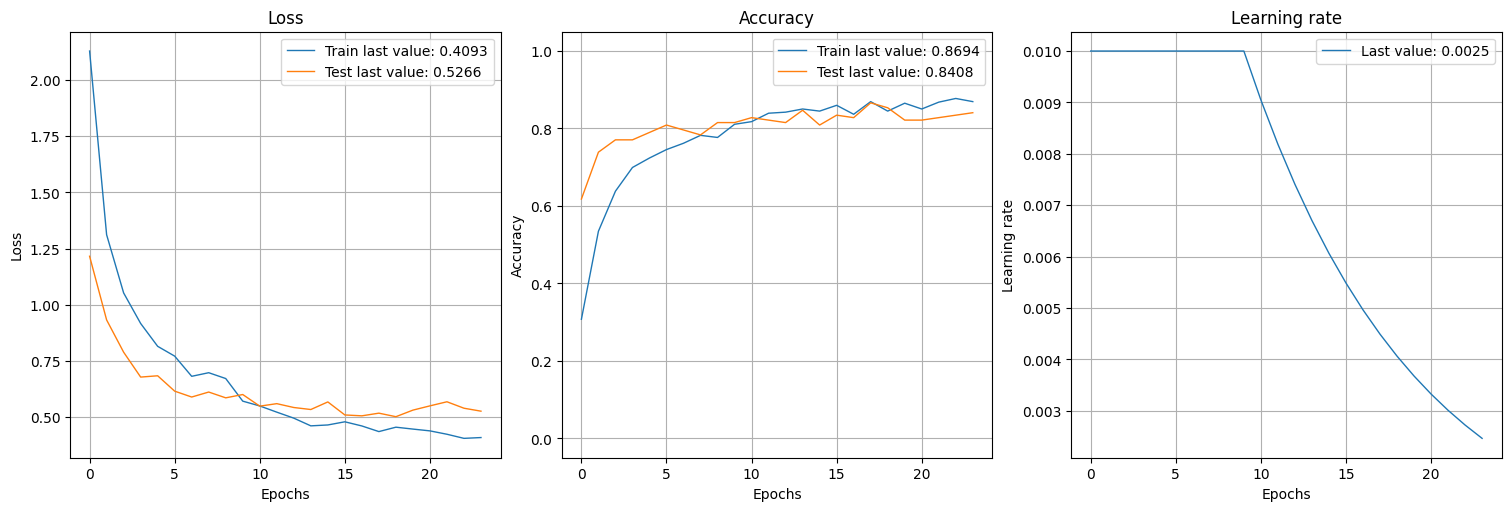

C:\Users\Imtech\AppData\Local\Temp\ipykernel_2720\1957530627.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


      Model epochs  dropout_rate optimization  accuracy validation  \
0  ResNet50     14           0.5         adam             0.872611   
1  ResNet50     24           0.5          sgd             0.834395   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.835443         0.547720   0.652251        2317.683192  
1       0.841772         0.522053   0.485590        3666.995985  
Training with hyperparameters: ResNet50_rmsprop_0.5
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D) 

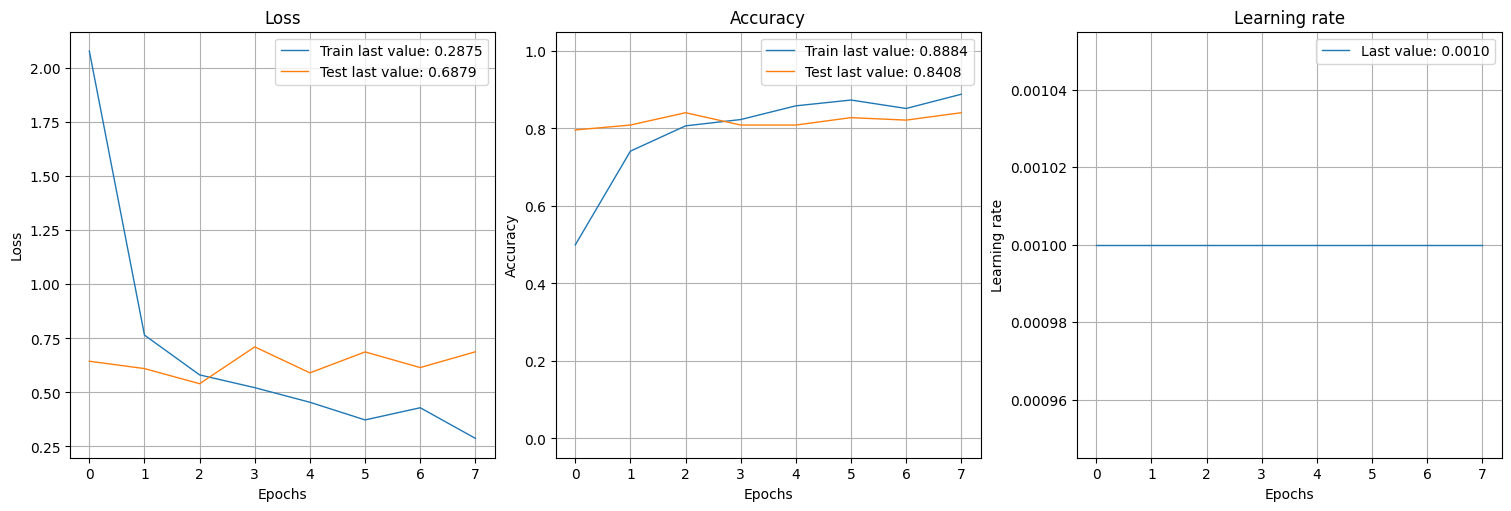

      Model epochs  dropout_rate optimization  accuracy validation  \
0  ResNet50     14           0.5         adam             0.872611   
1  ResNet50     24           0.5          sgd             0.834395   
2  ResNet50      8           0.5      rmsprop             0.840764   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.835443         0.547720   0.652251        2317.683192  
1       0.841772         0.522053   0.485590        3666.995985  
2       0.835443         0.644345   0.720870        1821.912302  
Training with hyperparameters: VGG16_adam_0.5
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                              

C:\Users\Imtech\AppData\Local\Temp\ipykernel_2720\1957530627.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


 block5_pool (MaxPooling2D)  (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 14,847,815
Trainable params: 133,127
Non-trainable params: 14,714,688
_________________________________________________________________
None
Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 4.9041 - accuracy: 0.3714 
Epoch 1: val_loss improv

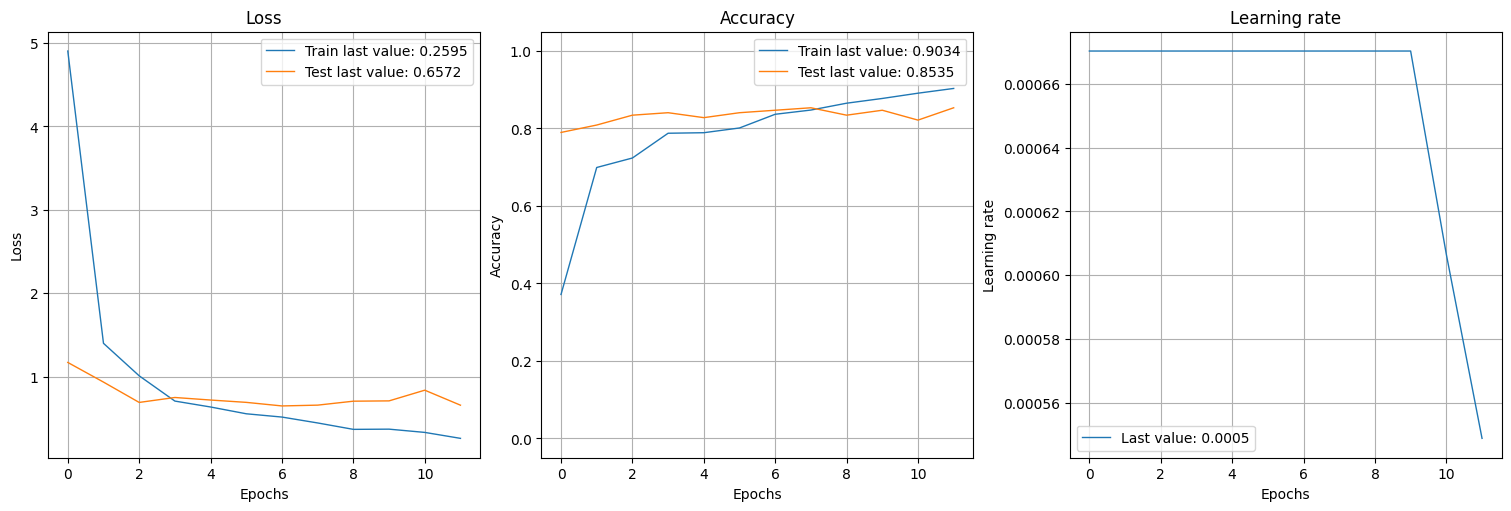

      Model epochs  dropout_rate optimization  accuracy validation  \
0  ResNet50     14           0.5         adam             0.872611   
1  ResNet50     24           0.5          sgd             0.834395   
2  ResNet50      8           0.5      rmsprop             0.840764   
3     VGG16     12           0.5         adam             0.821656   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.835443         0.547720   0.652251        2317.683192  
1       0.841772         0.522053   0.485590        3666.995985  
2       0.835443         0.644345   0.720870        1821.912302  
3       0.810127         0.895347   1.415832        4861.842073  
Training with hyperparameters: VGG16_sgd_0.5
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                           

C:\Users\Imtech\AppData\Local\Temp\ipykernel_2720\1957530627.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


                                                                 
 block4_conv3 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 14, 14, 512)       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
          

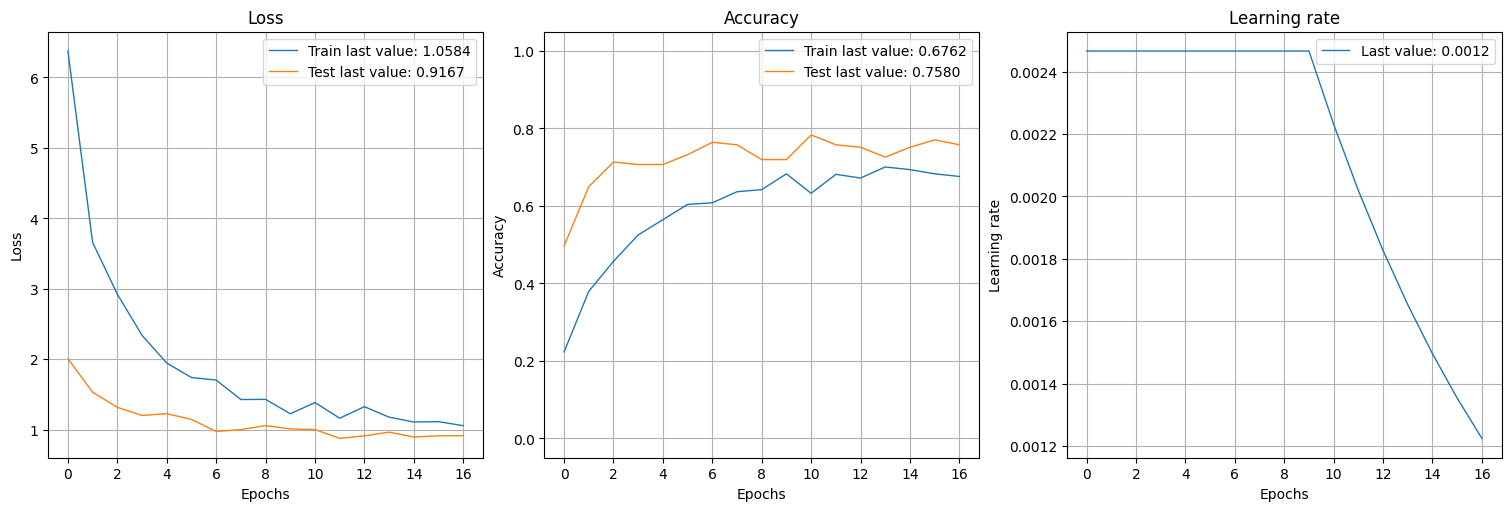

C:\Users\Imtech\AppData\Local\Temp\ipykernel_2720\1957530627.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


      Model epochs  dropout_rate optimization  accuracy validation  \
0  ResNet50     14           0.5         adam             0.872611   
1  ResNet50     24           0.5          sgd             0.834395   
2  ResNet50      8           0.5      rmsprop             0.840764   
3     VGG16     12           0.5         adam             0.821656   
4     VGG16     17           0.5          sgd             0.757962   

   accuracy test  loss validation  loss test  training_time (s)  
0       0.835443         0.547720   0.652251        2317.683192  
1       0.841772         0.522053   0.485590        3666.995985  
2       0.835443         0.644345   0.720870        1821.912302  
3       0.810127         0.895347   1.415832        4861.842073  
4       0.803797         0.848557   1.197052        4185.509256  
Training with hyperparameters: VGG16_rmsprop_0.5
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape          

: 

In [25]:
from plot_keras_history import show_history, plot_history

def schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create an empty DataFrame for post-treatment
results_df = pd.DataFrame(columns=['Model', 'epochs', 'dropout_rate', 'optimization', #'ARI',
                                   'accuracy validation', 'accuracy test',
                                   'loss validation', 'loss test',
                                   'training_time (s)'])

model_vgg_aug_opt = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_resnet_sup = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
dict_model = {'VGG16': model_vgg_aug_opt, 'ResNet50':model_resnet_sup}
dict_optimizer = {'adam': Adam(), 'sgd':SGD(), 'rmsprop':'rmsprop'}

# Define hyperparameters to tune
hyperparameters = {
    'model' : [dict_model['ResNet50'], dict_model['VGG16']],
    'n_class': [7],
    'dropout_rate': [0.5], #0.3
    'optimization': [dict_optimizer['adam'], dict_optimizer['sgd'], dict_optimizer['rmsprop']]
}

# Generate all combinations of hyperparameters
param_grid = list(ParameterGrid(hyperparameters))


# Iterate over hyperparameter combinations
for params in param_grid:
    model_name = list(filter(lambda x: dict_model[x] == params['model'], dict_model))[0]
    optimizer_name = list(filter(lambda x: dict_optimizer[x] == params['optimization'], dict_optimizer))[0]

    print(f"Training with hyperparameters: {model_name}_{optimizer_name}_{params['dropout_rate']}")

    # Record start time
    start_time = time.time()

    model = create_model_fct(**params)
    #model_name = params['model'].__class__.__name__

    # Create the callback
    model_save_path = f"./best_model_weights_{model_name}_{optimizer_name}_{params['dropout_rate']}.h5"
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    lr_scheduler = LearningRateScheduler(schedule)
    callbacks_list = [checkpoint, early_stopping, lr_scheduler]

    # Train the model on the training data
    history = model.fit(df_aug_dev_train_flow, validation_data=df_aug_dev_val_flow, epochs=50, batch_size=batch_size, 
                          callbacks=callbacks_list, verbose=1)

       # Train the model on the training data
    #history = model.fit(df_aug_dev_train_flow, y_aug_dev_train, validation_data=(X_sup_dev_val ,y_sup_dev_val),
    #                                      epochs=50, batch_size=batch_size, callbacks=callbacks_list, verbose=1)

    # Validation set evaluation
    loss_aug_dev_val, accuracy_aug_dev_val, = model.evaluate(df_aug_dev_val_flow, verbose=False)
    print("Validation Accuracy for {} Model data augmentation approach:  {:.4f}".format(model_name, accuracy_aug_dev_val,))

    # Test set evaluation
    loss_aug_test, accuracy_aug_test = model.evaluate(df_aug_dev_test_flow, verbose=False)
    print("Test Accuracy for {} Model data augmentation approach:  {:.4f}".format(model_name, accuracy_aug_test))

    # Record end time and calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    # save Plot
    show_history(history)
    plot_history(history, path="PLOT_{}_{}_{}.png".format(model_name, optimizer_name, params['dropout_rate']))
    plt.close()

    # Calculate ARI score on validation set
    #y_sup_dev_val_num = df_aug_dev_val_flow.classes
    #y_dev_test_pred = np.argmax(model.predict(df_aug_dev_val_flow), axis=1)
    #ari_score = adjusted_rand_score(y_sup_dev_val_num, y_dev_test_pred)
    #print("ARI: " + str(ari_score))

    # Update the results DataFrame
    results_df = results_df.append({
        'Model': model_name,
        'epochs': len(history.epoch),
        'dropout_rate': params['dropout_rate'],
        'optimization': optimizer_name,
        #'ARI': ari_score,
        'accuracy validation': accuracy_aug_dev_val,
        'accuracy test': accuracy_aug_test,
        'loss validation': loss_aug_dev_val,
        'loss test': loss_aug_test,
        'training_time (s)': training_time
    }, ignore_index=True)
    print(results_df)

#### 3-4 Post processing

In [ ]:
results_df

,Model,epochs,dropout_rate,optimization,accuracy validation,accuracy test,loss validation,loss test,training_time (s)
0,ResNet50,11,0.5,adam,0.866242,0.848101,0.493123,0.579897,986.415773
1,ResNet50,17,0.5,sgd,0.840764,0.829114,0.541272,0.553169,1456.038469
2,ResNet50,8,0.5,rmsprop,0.828025,0.822785,0.643581,0.606957,759.888236
3,VGG16,10,0.5,adam,0.815287,0.822785,0.846625,0.717780,1637.682578
4,VGG16,14,0.5,sgd,0.783440,0.778481,0.862618,0.792196,2453.163752
5,VGG16,12,0.5,rmsprop,0.853503,0.841772,0.926695,0.689787,2349.737253


In [ ]:
results_df['delta_accuracy'] = results_df['accuracy test'] - results_df['accuracy validation']
results_df['delta_loss'] = results_df['loss test'] - results_df['loss validation']
np.round(results_df, 2)

,Model,epochs,dropout_rate,optimization,accuracy validation,accuracy test,loss validation,loss test,training_time (s),delta_accuracy,delta_loss
0,ResNet50,11,0.5,adam,0.87,0.85,0.49,0.58,986.42,-0.02,0.09
1,ResNet50,17,0.5,sgd,0.84,0.83,0.54,0.55,1456.04,-0.01,0.01
2,ResNet50,8,0.5,rmsprop,0.83,0.82,0.64,0.61,759.89,-0.01,-0.04
3,VGG16,10,0.5,adam,0.82,0.82,0.85,0.72,1637.68,0.01,-0.13
4,VGG16,14,0.5,sgd,0.78,0.78,0.86,0.79,2453.16,-0.00,-0.07
5,VGG16,12,0.5,rmsprop,0.85,0.84,0.93,0.69,2349.74,-0.01,-0.24


* ResNet50_sgd_0.5

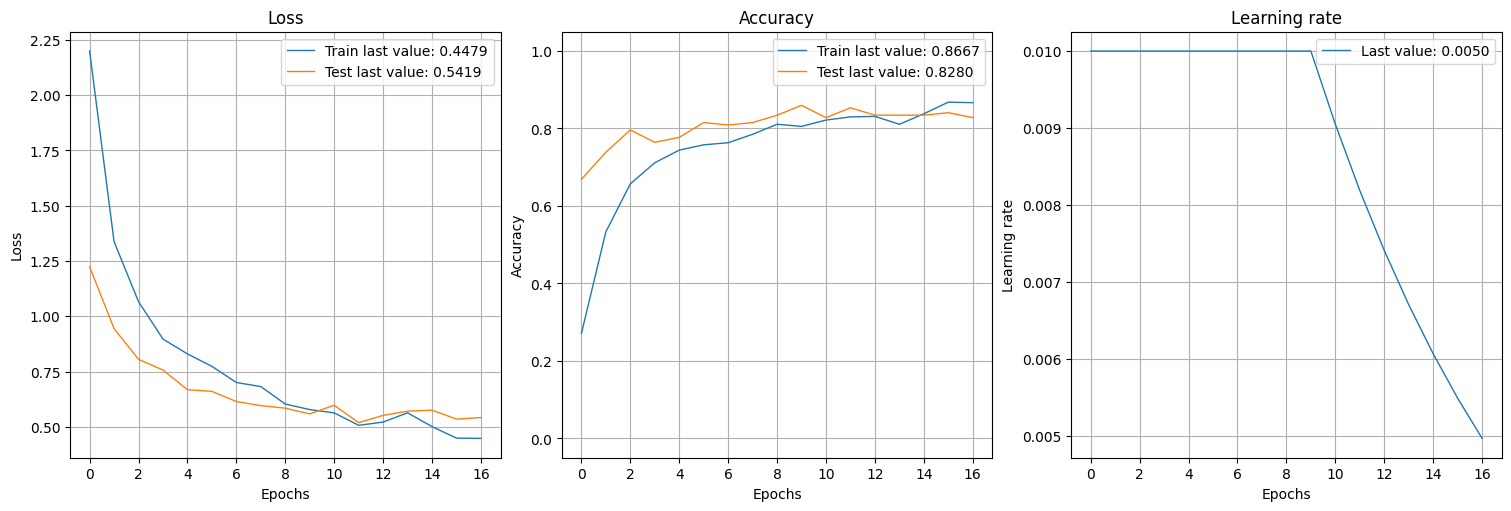


* VGG16_sgd_0.5

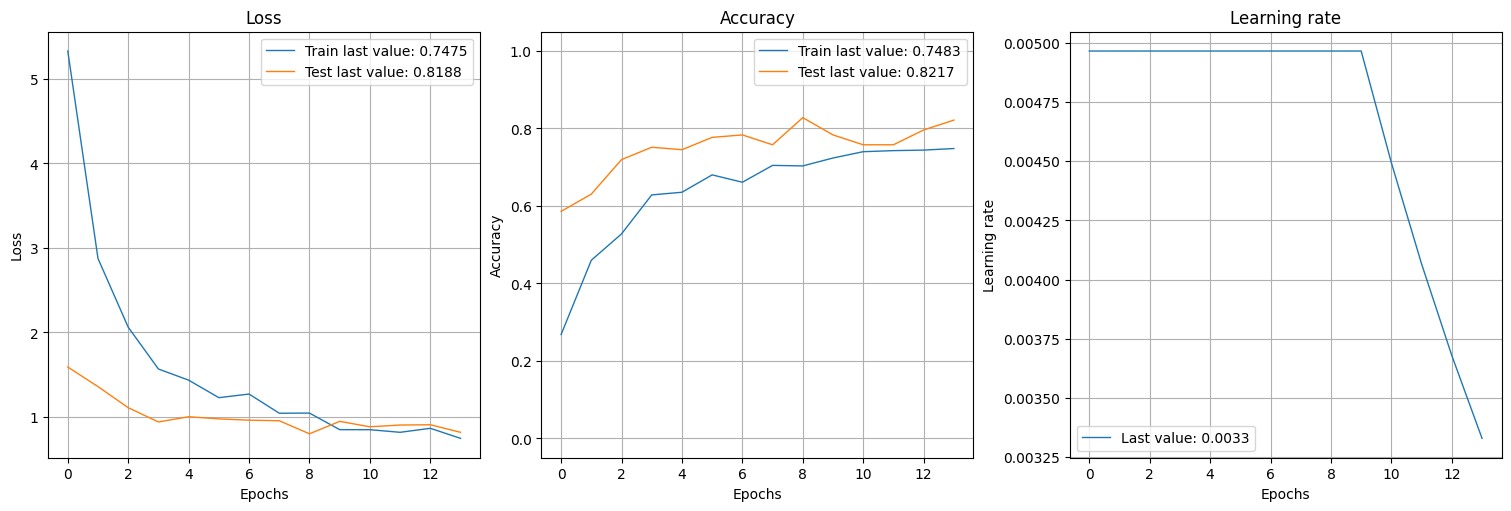